
# Title

### Customer Segmentation For Indonesia Credit Data

# Introduction

### Name : Sonny Riadi


`Project Description :`

In this project we gonna make a text classification using Natural Language Processing to determine the category of the article.


# External Link

1. Github
2. Deployment


# Working Area
This is where you handle the task


###  I. Import Library

In [320]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency



#### For Machine Learning ####

# split data into train and test
from sklearn.model_selection import train_test_split

#  handling outlier
from feature_engine.outliers import Winsorizer, OutlierTrimmer

# simple imputer
from sklearn.impute import SimpleImputer

# sklearn ColumnTransformer
from sklearn.compose import ColumnTransformer

# feature scaling and encoding
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

# pipeline
from sklearn.pipeline import Pipeline

# cros val score
from sklearn.model_selection import cross_val_score

# GridSearchCV
from sklearn.model_selection import GridSearchCV

#VIF (multicollinearity)
from statsmodels.stats.outliers_influence import variance_inflation_factor

#PCA
from sklearn.decomposition import PCA

# clustering
from sklearn.cluster import KMeans

# silhoutevisualization
from yellowbrick.cluster import SilhouetteVisualizer

# import metric silhouette_score
from sklearn.metrics import silhouette_score

# saving model
import pickle

# disable warning
import warnings
warnings.filterwarnings("ignore")

### II. Loading Dataset

In [321]:
df = pd.read_excel('Dataset/IndonesiaCreditData.xlsx',sheet_name='Dataset')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df.head(10)

,No,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,14494431,6,radio/TV
1,1,22,female,2,own,little,moderate,73786449,48,radio/TV
2,2,49,male,1,own,little,NaN,25988304,12,education
3,3,45,male,2,free,little,little,97728918,42,furniture/equipment
4,4,53,male,2,free,little,little,60383130,24,car
5,5,35,male,1,free,NaN,NaN,112272945,36,education
6,6,53,male,2,own,quite rich,NaN,35151165,24,furniture/equipment
7,7,35,male,3,rent,little,moderate,86148252,36,car
8,8,61,male,1,own,rich,NaN,37928541,12,radio/TV
9,9,28,male,3,own,little,moderate,64896366,30,car


dataset information :

- Age (numeric)
- Sex (text: male female)
- Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
- Housing (text: own rent or free)
- Saving accounts (text - little moderate, quite rich, rich)
- Checking account (numeric in DM - IDR)
- Credit amount (numeric in IDR)
- Duration (numeric in month)
- Purpose(text: car, furniture/equipment, radio/TV, domestic appliances, repairs, - education, business, vacation/others
-Risk (Value target - Good or Bad Risk)



In [322]:
df['Purpose'].value_counts()

car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: Purpose, dtype: int64

In [323]:
df.shape

(1000, 10)

### III. Data Cleaning & Preparation

##### 1. Remove Uneeded Column

In [324]:
df.drop(columns=['No'],inplace=True)
df.head(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,14494431,6,radio/TV
1,22,female,2,own,little,moderate,73786449,48,radio/TV
2,49,male,1,own,little,NaN,25988304,12,education
3,45,male,2,free,little,little,97728918,42,furniture/equipment
4,53,male,2,free,little,little,60383130,24,car
5,35,male,1,free,NaN,NaN,112272945,36,education
6,53,male,2,own,quite rich,NaN,35151165,24,furniture/equipment
7,35,male,3,rent,little,moderate,86148252,36,car
8,61,male,1,own,rich,NaN,37928541,12,radio/TV
9,28,male,3,own,little,moderate,64896366,30,car


##### 2. Remove Duplicates Data

In [325]:
df.drop_duplicates(inplace=True)
df.head(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,14494431,6,radio/TV
1,22,female,2,own,little,moderate,73786449,48,radio/TV
2,49,male,1,own,little,NaN,25988304,12,education
3,45,male,2,free,little,little,97728918,42,furniture/equipment
4,53,male,2,free,little,little,60383130,24,car
5,35,male,1,free,NaN,NaN,112272945,36,education
6,53,male,2,own,quite rich,NaN,35151165,24,furniture/equipment
7,35,male,3,rent,little,moderate,86148252,36,car
8,61,male,1,own,rich,NaN,37928541,12,radio/TV
9,28,male,3,own,little,moderate,64896366,30,car


### IV. Data Preprocessing

##### 1. Handling Outlier

In [326]:
num_cols = ['Age','Credit amount','Duration']

cat_cols = ['Sex','Job','Housing','Saving accounts','Checking account','Purpose']

In [327]:
def detect_outlier(data_name):
    #create dataframe with columns name : feature, distribution, outlier
    global dist_df,outlier_df
    outlier_df = pd.DataFrame(columns=['feature','distribution','left_tail','right_tail','outlier','percentage'])
    #create loop for each feature
    for i in range(len(data_name.columns)):
        #create if statement for each distribution
        if data_name.iloc[:,i].skew() > -0.5 and data_name.iloc[:,i].skew() < 0.5 :
            #count outlier for normal distribution based on z-score
            outlier_df.loc[i] = [data_name.columns[i],
                                'normal',
                                data_name.iloc[:,i][(stats.zscore(data_name.iloc[:,i],nan_policy='omit'))<-3].count(),
                                data_name.iloc[:,i][(stats.zscore(data_name.iloc[:,i],nan_policy='omit'))>3].count(),
                                data_name.iloc[:,i][abs(stats.zscore(data_name.iloc[:,i],nan_policy='omit'))>3].count(),
                                data_name.iloc[:,i][abs(stats.zscore(data_name.iloc[:,i],nan_policy='omit'))>3].count()/len(data_name.iloc[:,i])*100]
        else:
            #count outlier for skew distribution based on IQR
            Q1 = data_name.iloc[:,i].quantile(0.25)
            Q3 = data_name.iloc[:,i].quantile(0.75)
            IQR = Q3 - Q1
            outlier_df.loc[i] = [data_name.columns[i],
                                'skew',
                                data_name.iloc[:,i][(data_name.iloc[:,i]<(Q1-1.5*IQR))].count(),
                                data_name.iloc[:,i][(data_name.iloc[:,i]>(Q3+1.5*IQR))].count(),
                                data_name.iloc[:,i][(data_name.iloc[:,i]<(Q1-1.5*IQR))|(data_name.iloc[:,i]>(Q3+1.5*IQR))].count(),
                                data_name.iloc[:,i][(data_name.iloc[:,i]<(Q1-1.5*IQR))|(data_name.iloc[:,i]>(Q3+1.5*IQR))].count()/len(data_name.iloc[:,i])*100]
    dist_df = outlier_df
    outlier_df = outlier_df[
        (outlier_df['percentage'] != 0)
    ].sort_values(by='percentage',ascending=False)

    print('Generate dist_df & outlier_df')

detect_outlier(df[num_cols])
outlier_df

Generate dist_df & outlier_df


,feature,distribution,left_tail,right_tail,outlier,percentage
1,Credit amount,skew,0,72,72,7.200
2,Duration,skew,0,70,70,7.000
0,Age,skew,0,23,23,2.300


In [328]:
# create function to handling outliers
def handling_outlier(data):
    global df
    norm_under_5 = outlier_df[outlier_df['distribution'] ==
                              'normal'][outlier_df['percentage'] < 5]['feature'].tolist()
    norm_over_5 = outlier_df[outlier_df['distribution'] ==
                             'normal'][outlier_df['percentage'] > 5]['feature'].tolist()
    skew_under_5 = outlier_df[outlier_df['distribution'] ==
                              'skew'][outlier_df['percentage'] < 5]['feature'].tolist()
    skew_over_5 = outlier_df[outlier_df['distribution'] ==
                             'skew'][outlier_df['percentage'] > 5]['feature'].tolist()

    # modify if there's any exception list
    norm_under_5 = [x for x in norm_under_5 if x not in exception_list]
    skew_under_5 = [x for x in skew_under_5 if x not in exception_list]
    norm_over_5 = [x for x in norm_over_5 if x not in exception_list]
    skew_over_5 = [x for x in skew_over_5 if x not in exception_list]

    custom_list = ['norm_under_5', 'norm_over_5',
                   'skew_under_5', 'skew_over_5']

    for i in custom_list:
        if i == 'norm_under_5' and len(norm_under_5) != 0:

            trim_norm = OutlierTrimmer(capping_method='gaussian',
                                       tail='both',  # left/right/both
                                       fold=3,  # for gaussian 2 or 3
                                       variables=norm_under_5,
                                       missing_values='ignore')
            trim_norm.fit(df)

            df = trim_norm.transform(df)


        elif i == 'norm_over_5' and len(norm_over_5) != 0:

            winsorizer_norm = Winsorizer(capping_method='gaussian',
                                         tail='both',  # left/right/both
                                         fold=3,  # for gaussian 2 or 3
                                         variables=norm_over_5,
                                         missing_values='ignore')
            winsorizer_norm.fit(df)

            df = winsorizer_norm.transform(df)

        elif i == 'skew_under_5' and len(skew_under_5) != 0:

            trim_skew = OutlierTrimmer(capping_method='iqr',
                                       tail='both',  # left/right/both
                                       fold=1.5,  # for iqr 1 or 2
                                       variables=skew_under_5,
                                       missing_values='ignore')
            trim_skew.fit(df)

            df = trim_skew.transform(df)

        elif i == 'skew_over_5' and len(skew_over_5) != 0:

            winsorizer_skew = Winsorizer(capping_method='iqr',
                                         tail='both',  # left/right/both
                                         fold=1.5,  # for iqr 1 or 2
                                         variables=skew_over_5,
                                         missing_values='ignore')
            winsorizer_skew.fit(df)

            df = winsorizer_skew.transform(df)

    print('Handling outliers Success!')



In [329]:
print('Before Handlign Outlier',df.shape)
exception_list = []
handling_outlier(df[num_cols])
print('After Handling Outlier',df.shape)

Before Handlign Outlier (1000, 9)
Handling outliers Success!
After Handling Outlier (977, 9)


In [330]:
#check the outlier
detect_outlier(df[num_cols])
outlier_df

Generate dist_df & outlier_df


,feature,distribution,left_tail,right_tail,outlier,percentage
0,Age,skew,0,13,13,1.331


#####  2. Handling Missing Values

we will handling missing values using pipeline

##### 3. Feature Scaling & Encoding

In [331]:
norm_list = dist_df[dist_df['distribution'] ==
                       'normal']['feature'].tolist()
                       
skew_list = dist_df[dist_df['distribution']
                       == 'skew']['feature'].tolist()

ordinal_category_list = [
    'Job',
    'Housing',
    'Saving accounts',
    'Checking account'
]

nominal_category_list = ['Sex','Purpose']

In [332]:
df_2 = pd.get_dummies(df[nominal_category_list],prefix=nominal_category_list).reset_index(drop=True)
df_2

,Sex_female,Sex_male,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,1,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,1,0,0,0
3,0,1,0,1,0,0,0,0,0,0
4,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
972,1,0,0,0,0,0,1,0,0,0
973,0,1,0,1,0,0,0,0,0,0
974,0,1,0,0,0,0,0,1,0,0
975,0,1,0,0,0,0,0,1,0,0


In [333]:
nominal_category_list

['Sex', 'Purpose']

In [334]:
df_3 = df.drop(columns=nominal_category_list)

In [335]:
pipe_cat_ord = Pipeline([
    ('cat_ord_imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('cat_ord', OrdinalEncoder())
])

# pipe_cat_num = Pipeline([
#     ('cat_num_imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
#     ('cat_num', OneHotEncoder(handle_unknown='ignore'))
# ])

pipe_norm_num = Pipeline([
    ('norm_num_imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('norm_num', StandardScaler())
])

pipe_skew_num = Pipeline([
    ('skew_num_imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('skew_num', StandardScaler())
])

pipe_fe = ColumnTransformer([
    ('pipe_cat_ord', pipe_cat_ord, ordinal_category_list),
    # ('pipe_cat_num', pipe_cat_num, nominal_category_list),
    ('pipe_norm_num', pipe_norm_num, norm_list),
    ('pipe_skew_num', pipe_skew_num, skew_list)

])


In [336]:
df_3

,Age,Job,Housing,Saving accounts,Checking account,Credit amount,Duration
1,22,2,own,little,moderate,73786449.000,42.000
2,49,1,own,little,NaN,25988304.000,12.000
3,45,2,free,little,little,97567731.000,42.000
4,53,2,free,little,little,60383130.000,24.000
5,35,1,free,NaN,NaN,97567731.000,36.000
...,...,...,...,...,...,...,...
995,31,1,own,little,NaN,21524664.000,12.000
996,40,3,own,little,little,47822943.000,30.000
997,38,2,own,little,NaN,9968796.000,12.000
998,23,2,free,little,little,22876155.000,42.000


In [341]:
df_3['Job'].value_counts()

2    624
1    197
3    139
0     17
Name: Job, dtype: int64

In [337]:
data_scale = pipe_fe.fit_transform(df_3)

# create dataframe from data_scale
data_scale_df = pd.DataFrame(data_scale,columns=df_3.columns)

Saving pipe_fe.pkl

In [319]:
with open('pipe_fe.pkl', 'wb') as f:
    pickle.dump(pipe_fe, f, protocol=pickle.HIGHEST_PROTOCOL)


##### 4. Variance Inflation Factor (VIF)

In [210]:
# create looping to check Variance inflation factor < 5

vif_data = pd.DataFrame(columns=['feature','vif'])

for i in range(len(data_scale_df.columns)) :
    if variance_inflation_factor(data_scale_df.values,i) < 5:
        vif_data.loc[i] = [data_scale_df.columns[i],variance_inflation_factor(data_scale_df.values,i)]

    vif_data.reset_index(drop=True,inplace=True)

vif_data   

,feature,vif
0,Age,4.017099
1,Job,3.918662
2,Housing,1.219657
3,Saving accounts,1.373100
4,Checking account,1.075878
5,Credit amount,1.795968
6,Duration,1.782211


theres 7 features that have VIF 

In [211]:
pca_vif=PCA(n_components=7).fit(data_scale_df)
pca_vif.explained_variance_ratio_

array([0.36450826, 0.22004153, 0.13798132, 0.0816952 , 0.07584194,
       0.07063771, 0.04929404])

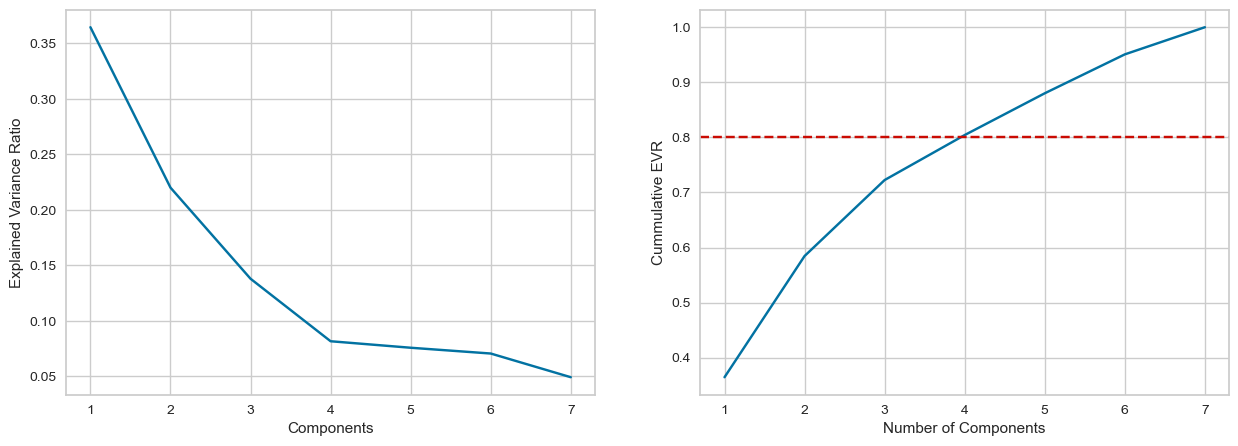

In [212]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(range(1,8),pca_vif.explained_variance_ratio_)
plt.xlabel('Components')
plt.ylabel('Explained Variance Ratio')

plt.subplot(1,2,2)
plt.plot(range(1,8),np.cumsum(pca_vif.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cummulative EVR')
plt.axhline(y=0.8,color='r',linestyle='--')

plt.show()

In [213]:
pca_preprocessing = PCA(n_components=0.8).fit(data_scale_df)
pca_preprocessing.n_components_

4

In [214]:
data_reduce = pca_preprocessing.transform(data_scale_df)

In [215]:
data_reduce_df = pd.DataFrame(data_reduce)
data_reduce_df

,0,1,2,3
0,2.311976,-1.403483,-0.099630,0.690885
1,-0.918741,1.407549,-0.532161,0.375724
2,3.108048,1.001149,-0.261321,0.206539
3,1.020930,1.896087,-0.472245,-0.150733
4,2.499797,0.076486,-0.278368,0.660290
...,...,...,...,...
972,-1.109129,-0.298389,-0.452232,0.323542
973,1.124953,0.454259,-0.309237,-0.637283
974,-1.198902,0.386327,-0.480106,-0.286561
975,1.097773,-1.046679,-0.170514,0.785509


Saving pca_preprocessing.pkl


In [342]:
with open('pca_pp.pkl', 'wb') as f:
    pickle.dump(pca_preprocessing, f, protocol=pickle.HIGHEST_PROTOCOL)


### V. Model Definition

In [216]:
random = 12

In [217]:
kmeans = KMeans(random_state=random)

### VI. Model Training

In [218]:
kmeans.fit(data_reduce_df)

KMeans(random_state=12)

### VII. Model Evaluation

In [219]:
# predict the cluster
pred_kmeans = kmeans.predict(data_reduce_df)

Kmeans_df = data_reduce_df.copy()
Kmeans_df['Cluster'] = pred_kmeans + 1

In [220]:
pca = PCA(n_components=2)
Kmeans_pca = pca.fit_transform(data_reduce_df)
Kmeans_pca = pd.DataFrame.from_records(data=Kmeans_pca, columns=["x1","x2"])
Kmeans_pca["Cluster"] = pred_kmeans + 1

In [221]:
Kmeans_pca

,x1,x2,Cluster
0,2.311976,-1.403483,6
1,-0.918741,1.407549,3
2,3.108048,1.001149,2
3,1.020930,1.896087,2
4,2.499797,0.076486,6
...,...,...,...
972,-1.109129,-0.298389,1
973,1.124953,0.454259,2
974,-1.198902,0.386327,7
975,1.097773,-1.046679,8


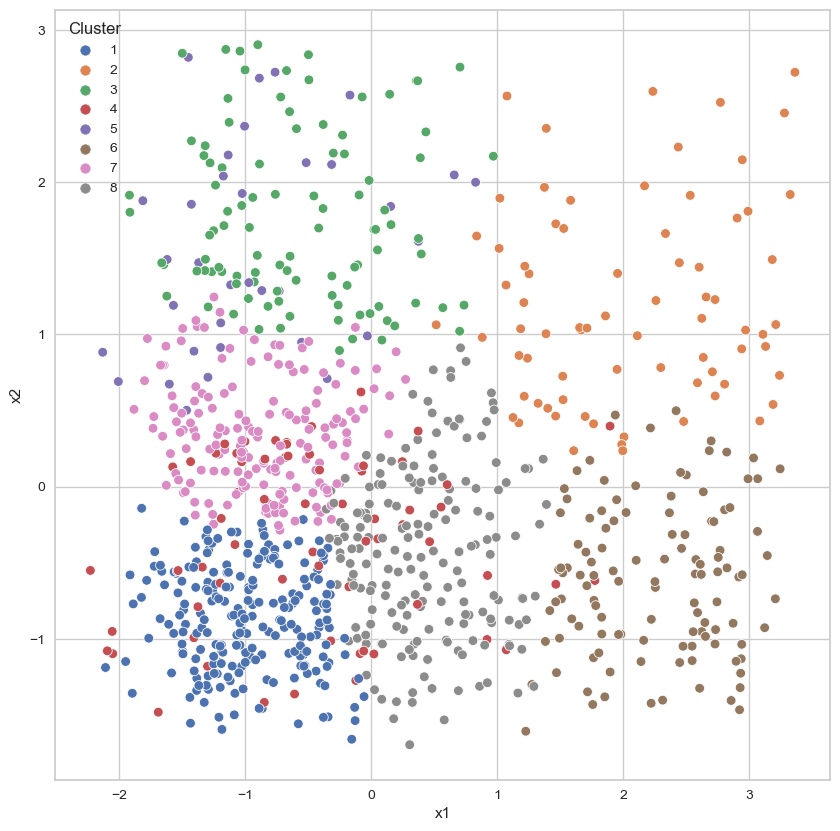

In [222]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="x1", y="x2", hue="Cluster", data=Kmeans_pca, palette="deep")
plt.show()


### Model Tuning

##### Elbow Method

Text(0, 0.5, 'Inertia')

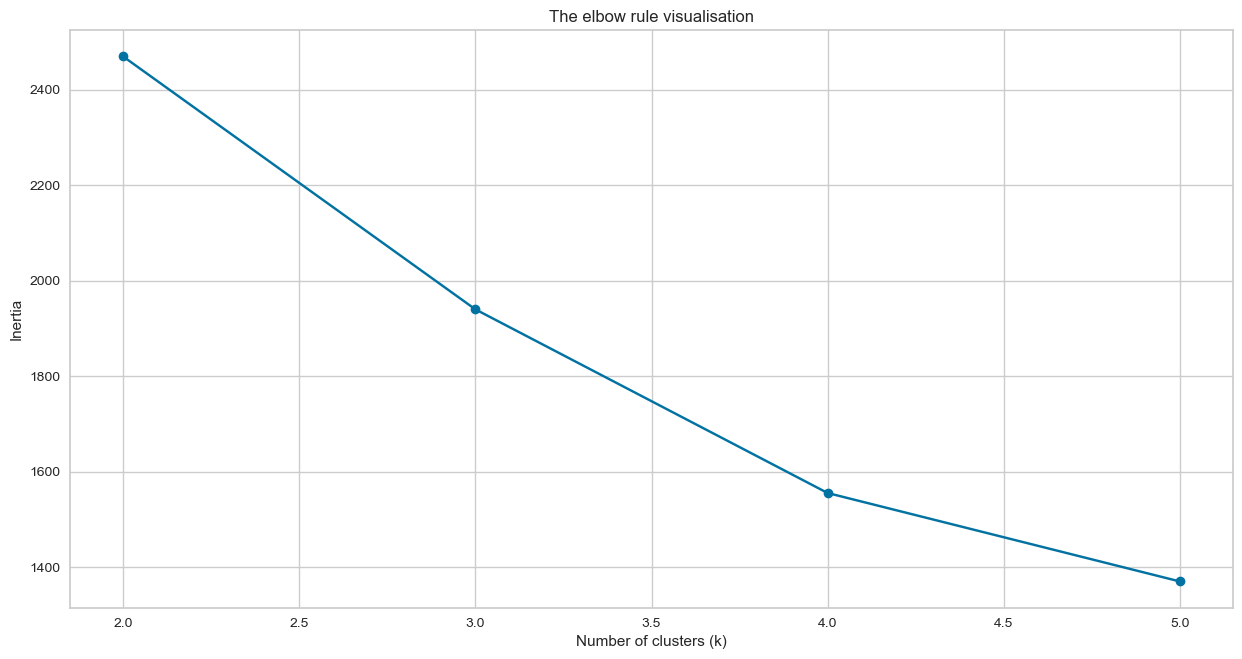

In [223]:
k_range = range(2,6)
inertias = []

for n_clusters in k_range:
    model = KMeans(n_clusters, random_state=random, init='k-means++', n_init=10, max_iter=50).fit(data_reduce_df)
    inertias.append(model.inertia_)

plt.figure(figsize=(15,7.5))  
plt.title("The elbow rule visualisation")
plt.plot(k_range, inertias, '-o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')



##### Silhouette Score & Plot

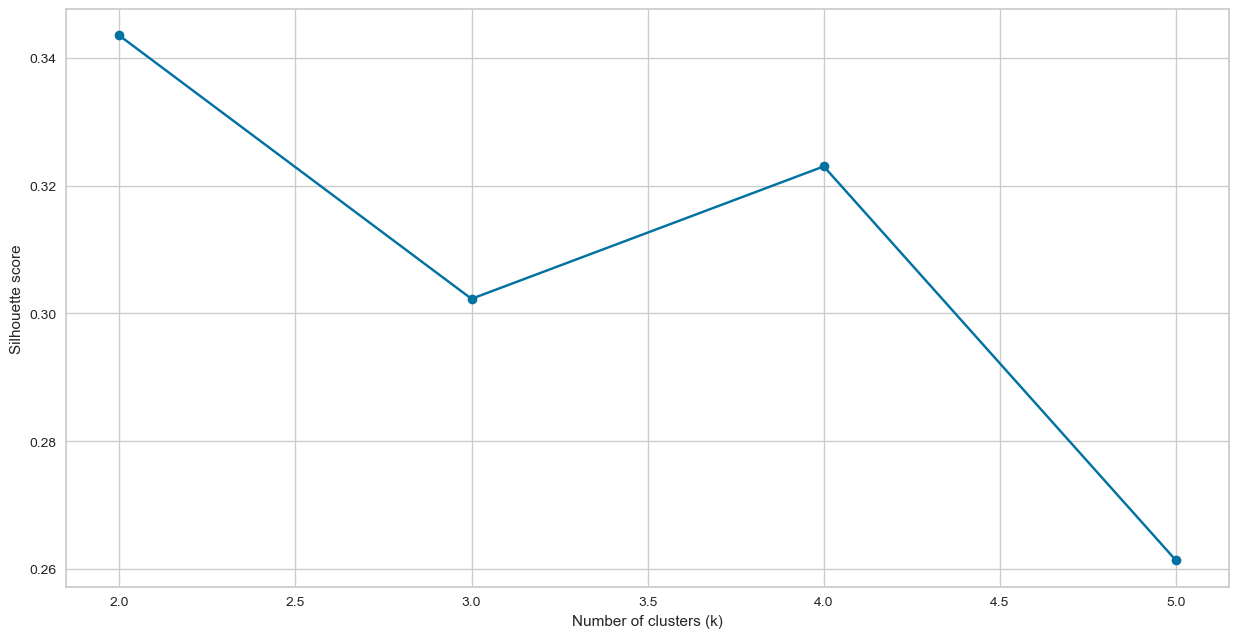

In [224]:
model_per_k = [KMeans(n_clusters=i, random_state=random, init='k-means++', n_init=10).fit(data_reduce_df) for i in k_range]
silhouette_scores = [silhouette_score(data_reduce_df,model.labels_) for model in model_per_k]

# plot the silhouette scores
plt.figure(figsize=(15,7.5))
plt.plot(k_range, silhouette_scores, '-o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.show()

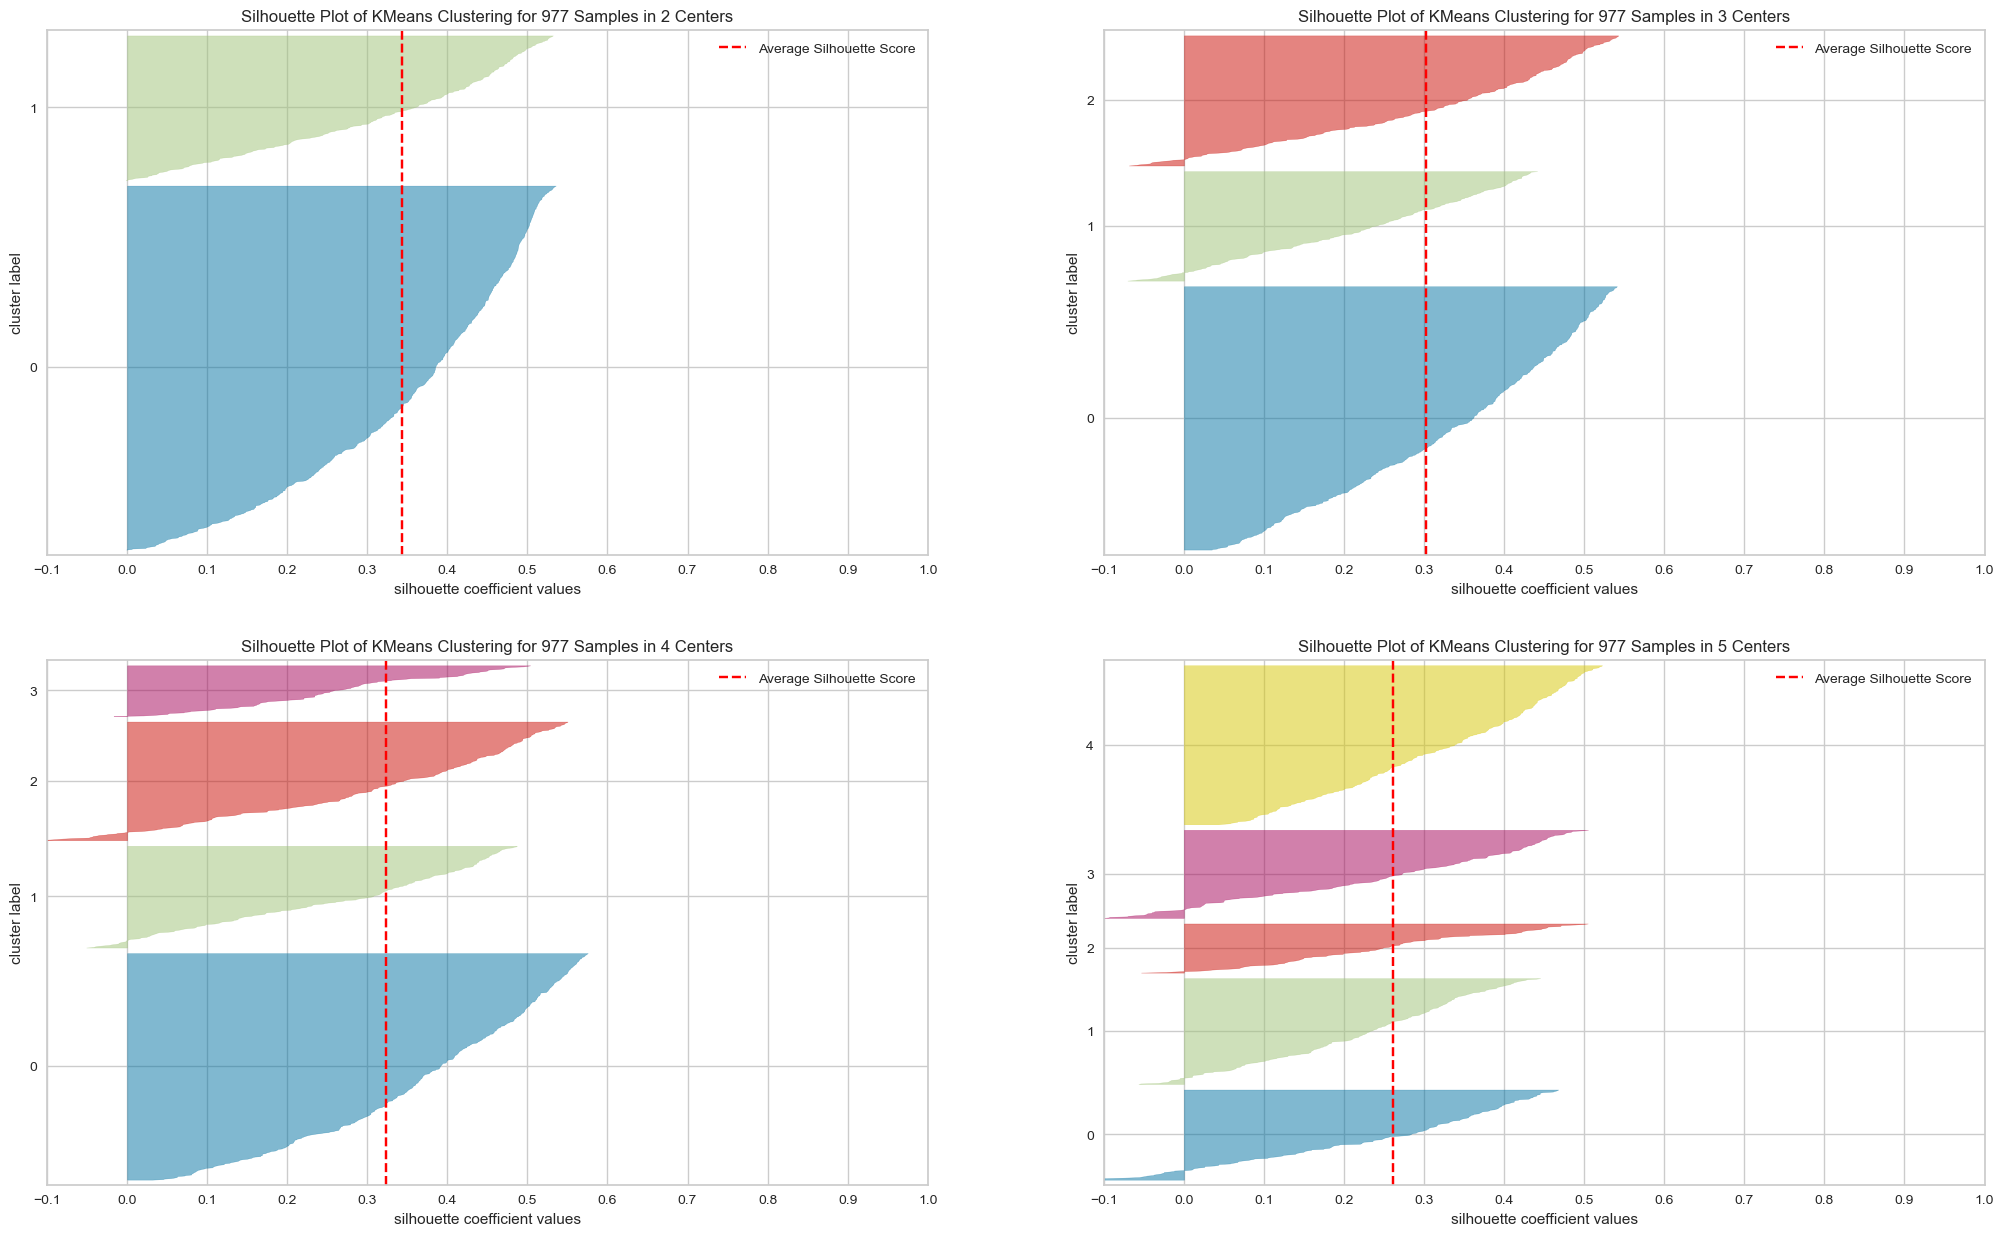

In [225]:
k_range = range(2,6)
fig, axs = plt.subplots(nrows=round(len(k_range)/2), ncols=2, figsize=(25,7.5*round(len(k_range)/2)))

for i in k_range:
    model = KMeans(i, init='k-means++', n_init=10, random_state=random)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick',ax=axs[(i-2)//2,(i-2)%2])
    visualizer.fit(data_reduce_df)
    visualizer.finalize()
    axs[(i-2)//2,(i-2)%2].set_xlim(-0.1, 1)


##### Predict with K=3

In [226]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=random)
kmeans.fit(data_reduce_df)

pred_kmeans_tuning = kmeans.predict(data_reduce_df)

data_cleaned_clustered = data_reduce_df.copy()
data_cleaned_clustered['Cluster'] = pred_kmeans_tuning + 1

In [227]:
pca = PCA(n_components=2)
kmeans_data = pca.fit_transform(data_reduce_df)
kmeans_pca_df = pd.DataFrame.from_records(data=kmeans_data, columns=["x1","x2"])
kmeans_pca_df["Cluster"] = pred_kmeans_tuning + 1

In [228]:
kmeans_pca_df

,x1,x2,Cluster
0,2.311976,-1.403483,3
1,-0.918741,1.407549,2
2,3.108048,1.001149,3
3,1.020930,1.896087,2
4,2.499797,0.076486,3
...,...,...,...
972,-1.109129,-0.298389,1
973,1.124953,0.454259,3
974,-1.198902,0.386327,1
975,1.097773,-1.046679,3


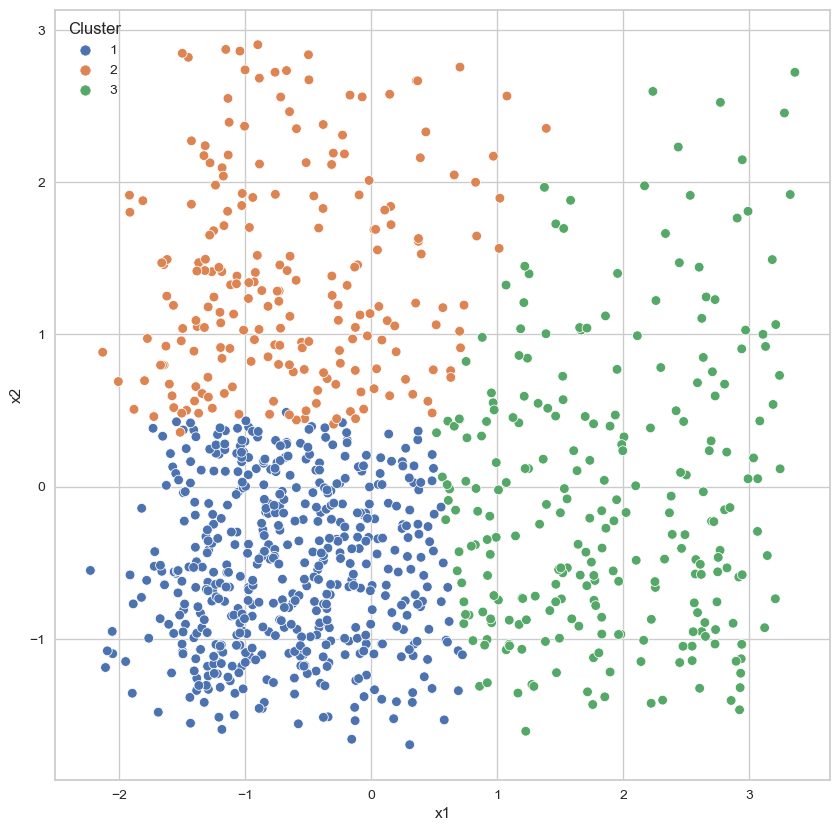

In [229]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="x1", y="x2", hue="Cluster", data=kmeans_pca_df, palette="deep")
plt.show()

Saving Clustering Model

In [ ]:
with open('cluster_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f, protocol=pickle.HIGHEST_PROTOCOL)


### Exploratory Data Analysis (EDA) Clustering Model

In [230]:
df.reset_index(inplace=True,drop=True)

# concat data and kmeans_pca_df
df_cluster = pd.concat([df,kmeans_pca_df['Cluster']],axis=1)
df_cluster


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Cluster
0,22,female,2,own,little,moderate,73786449.0,42.0,radio/TV,3
1,49,male,1,own,little,NaN,25988304.0,12.0,education,2
2,45,male,2,free,little,little,97567731.0,42.0,furniture/equipment,3
3,53,male,2,free,little,little,60383130.0,24.0,car,2
4,35,male,1,free,NaN,NaN,97567731.0,36.0,education,3
...,...,...,...,...,...,...,...,...,...,...
972,31,female,1,own,little,NaN,21524664.0,12.0,furniture/equipment,1
973,40,male,3,own,little,little,47822943.0,30.0,car,3
974,38,male,2,own,little,NaN,9968796.0,12.0,radio/TV,1
975,23,male,2,free,little,little,22876155.0,42.0,radio/TV,3


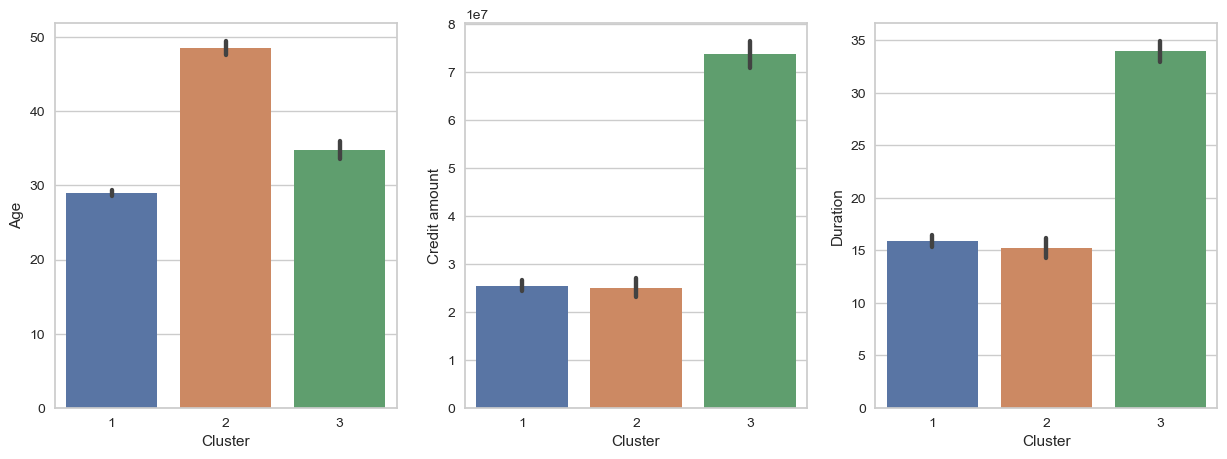

In [268]:
# plot distribution of each feature
fig, axs = plt.subplots(1,3, figsize=(15,5))
sns.barplot(data=df_cluster, x='Cluster', y='Age' ,palette='deep', ax=axs[0])
sns.barplot(data=df_cluster, x='Cluster', y='Credit amount' ,palette='deep', ax=axs[1])
sns.barplot(data=df_cluster, x='Cluster', y='Duration' ,palette='deep', ax=axs[2])
fig.show()

In [286]:
df_cluster

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Cluster
0,22,female,2,own,little,moderate,73786449.0,42.0,radio/TV,3
1,49,male,1,own,little,NaN,25988304.0,12.0,education,2
2,45,male,2,free,little,little,97567731.0,42.0,furniture/equipment,3
3,53,male,2,free,little,little,60383130.0,24.0,car,2
4,35,male,1,free,NaN,NaN,97567731.0,36.0,education,3
...,...,...,...,...,...,...,...,...,...,...
972,31,female,1,own,little,NaN,21524664.0,12.0,furniture/equipment,1
973,40,male,3,own,little,little,47822943.0,30.0,car,3
974,38,male,2,own,little,NaN,9968796.0,12.0,radio/TV,1
975,23,male,2,free,little,little,22876155.0,42.0,radio/TV,3


In [289]:
df_cluster[['Age','Credit amount','Duration','Cluster']].groupby('Cluster').mean()


,Age,Credit amount,Duration
Cluster,,,
1,28.996,25480697.190,15.920
2,48.549,24930023.155,15.183
3,34.830,73752682.553,33.972


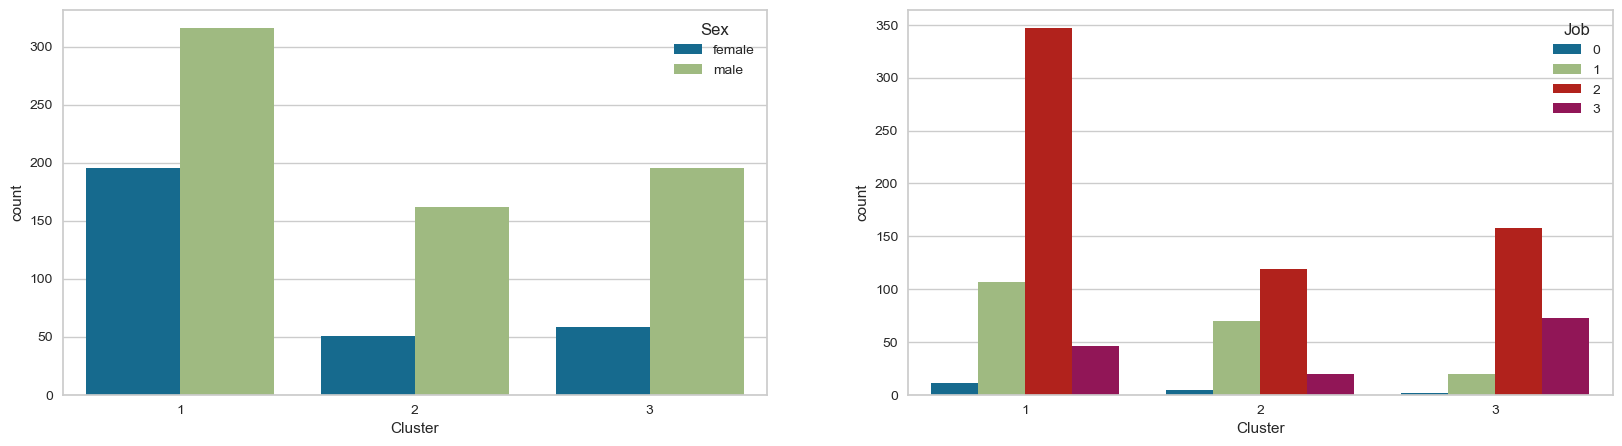

In [283]:
fig, axs = plt.subplots(1,2, figsize=(20,5))
sns.countplot(x = df_cluster['Cluster'],hue= df_cluster['Sex'],ax=axs[0])
sns.countplot(x = df_cluster['Cluster'],hue= df_cluster['Job'],ax=axs[1])
plt.show()

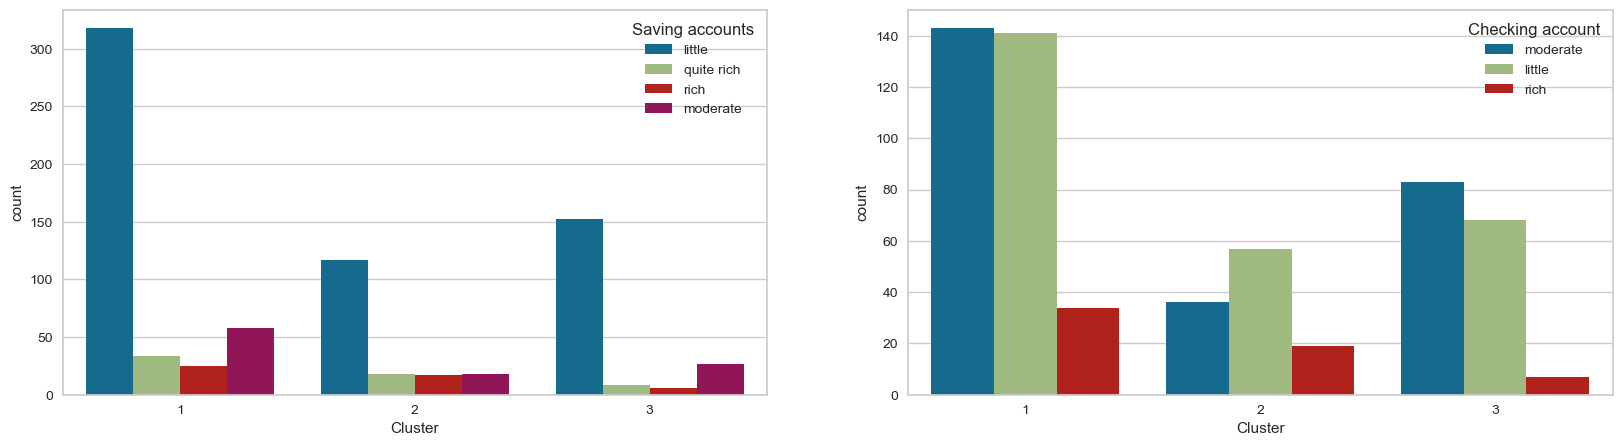

In [282]:
fig, axs = plt.subplots(1,2, figsize=(20,5))
sns.countplot(x = df_cluster['Cluster'],hue= df_cluster['Saving accounts'],ax=axs[0])
sns.countplot(x = df_cluster['Cluster'],hue= df_cluster['Checking account'],ax=axs[1])
plt.show()

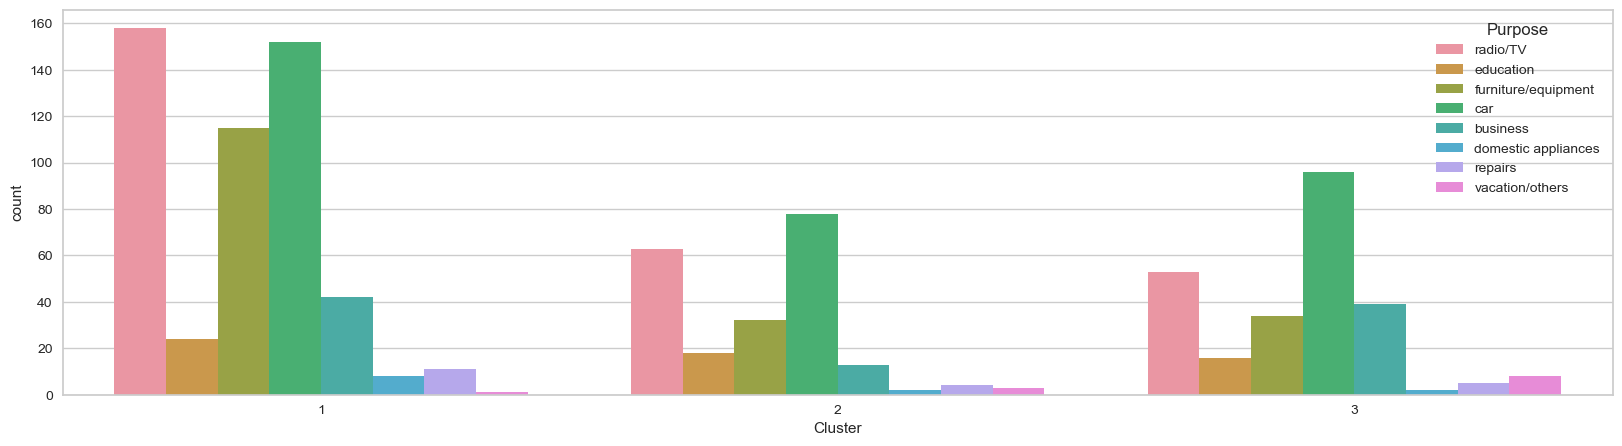

In [281]:
fig, axs = plt.subplots(1, figsize=(20,5))
sns.countplot(x = df_cluster['Cluster'],hue= df_cluster['Purpose'],)
plt.show()

Summary :

* Cluster 1 :
    - Age : Average Age 28 Years Old (Adult)
    - Credit Amount : Average IDR 25 Milion (Low)
    - Duration : Average duration 15 Month
    - Job : Mostly Skilled
    - Saving Account : Mostly little
    - Checking Account : Mostly Moderate & Little
    - Purpose : Mostly for Radio/TV, Furniture/equipment, Car
* Cluster 2 :
    - Age : Average Age 48 Years Old (Senior Citizen)
    - Credit Amount : Average IDR 25 Milion (Low)
    - Duration : Average duration 15 Month
    - Job : Mostly Skilled
    - Saving Account : Mostly little
    - Checking Account : Mostly Moderate & Little
    - Purpose : Mostly for Radio/TV, Car
* Cluster 3 :
    - Age : Average Age 34 Years Old (Adult)
    - Credit Amount : Average IDR 74 Milion (High)
    - Duration : Average duration 33 Month
    - Job : Mostly Skilled
    - Saving Account : Mostly little
    - Checking Account : Mostly Moderate & Little
    - Purpose : Mostly for Radio/TV, Car



# Conclusion / Overall Analysis
Write your findings, conclusion, and/or overall analysis here.